# Parole Models: Initial data exploration, cleaning, & processing

### Willie Costello

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize']=(8.0, 6.0)
%config InlineBackend.figure_format='retina'

## Importing & cleaning data

In [2]:
df_raw = pd.read_csv('~/data/ParoleModels/data.csv')

In [3]:
df_raw.shape

(744958, 26)

In [4]:
# Check for duplicates
df_raw.duplicated().sum()

0

In [5]:
# Check for missing values
df_raw.isna().mean().sort_values()

FISCAL YEAR                     0.000000
WARRANT ID                      0.000000
LOCATION TYPE                   0.000000
PROVINCE                        0.000000
OFFENCE ID                      0.000000
SENTENCE TYPE                   0.000000
JURISDICTION                    0.000000
OFFENCE DESCRIPTION             0.000000
AGE                             0.000000
GENDER                          0.000000
RACE GROUPING                   0.000000
OFFENDER NUMBER                 0.000000
IN CUSTODY/COMMUNITY            0.000000
SENTENCE ID                     0.000000
AGGREGATE SENTENCE LENGTH       0.000008
COURT                           0.014460
RACE                            0.017673
STATIC/RISK                     0.029078
DYNAMIC/NEED                    0.029407
REINTEGRATION POTENTIAL         0.030132
MOTIVATION                      0.030594
OFFENDER SECURITY LEVEL         0.065860
RELIGION                        0.070193
INSTUTUTIONAL SECURITY LEVEL    0.317110
SUPERVISION TYPE

`JUDGE` column is 100% missing values, so we will drop it. We will also here drop `RACE GROUPING`, `RELIGION`, `COURT`, `LOCATION TYPE`, `WARRANT ID`, `OFFENCE ID`, and `SENTENCE ID` since we will not be making use of these data. In addition, because `REINTEGRATION POTENTIAL` is the column we're looking to predict, we will drop all rows with missing values in this column.

In [6]:
df_clean = df_raw.drop(['JUDGE', 'PROVINCE', 'RACE GROUPING', 'RELIGION', 'COURT', 'LOCATION TYPE', 
                        'WARRANT ID', 'OFFENCE ID', 'SENTENCE ID', 'OFFENDER SECURITY LEVEL'], axis=1)
df_clean.dropna(subset=['REINTEGRATION POTENTIAL'], inplace=True)

The `INSTUTUTIONAL (sic) SECURITY LEVEL` and `SUPERVISION TYPE` columns also have a high percentage of missing values, but they are complementary: records with missing `INSTITUTIONAL SECURITY LEVEL` values have a `SUPERVISION TYPE` value, and vice versa. This is because inmates without an institutional security level are no longer in custody but in the community, and thus have a supervision type, and inmates without a supervision type are not in the community but in custody, and thus have an institutional security level.

Here we will combine the data from these two columns in a new single column, `SECURITY/SUPERVISION`. The rows with missing values in this new column will then be dropped.

In [7]:
# Combine Institutional Security Level and Supervision Type values into single column
df_clean['SECURITY/SUPERVISION'] = df_clean['INSTUTUTIONAL SECURITY LEVEL'].fillna(df_clean['SUPERVISION TYPE'])

# Drop Institutional Security Level, Supervision Type, and In Custody/Community columns
df_clean.drop(['INSTUTUTIONAL SECURITY LEVEL', 'SUPERVISION TYPE', 'IN CUSTODY/COMMUNITY'], axis=1, inplace=True)

Let's next convert the `FISCAL YEAR` column into something more descriptive.

In [8]:
df_clean['YEAR'] = df_clean['FISCAL YEAR'].apply(lambda x: '20' + x[-2:])

Let's now convert the `DETERMINATE SENTENCE` column into a binary column.

In [9]:
df_clean['DETERMINATE_SENTENCE'] = np.where(df_clean['SENTENCE TYPE']=='DETERMINATE', 1, 0)

In [10]:
# Round Offender Number to five decimal points, to fix some datatype issues
df_clean['OFFENDER ID'] = df_clean['OFFENDER NUMBER'].apply(lambda x: round(x, 5))

In [11]:
# Drop converted columns
df_clean.drop(['FISCAL YEAR', 'SENTENCE TYPE', 'OFFENDER NUMBER'], axis=1, inplace=True)

In [12]:
# Reformat column names
df_clean.columns = [x.lower().replace(' ', '_') for x in df_clean.columns]

In [13]:
# Drop remaining missing values
df_clean.dropna(inplace=True)

In [14]:
df_clean.shape

(710831, 14)

In [15]:
df_clean.head()

,race,gender,age,jurisdiction,aggregate_sentence_length,dynamic/need,static/risk,reintegration_potential,motivation,offence_description,security/supervision,year,determinate_sentence,offender_id
0,White,MALE,23,FEDERAL,1096.0,MEDIUM,LOW,HIGH,HIGH,POSS PROH/RESTR F/ARM W/AMMUN,MINIMUM,2012,1,82.50710
1,White,MALE,23,FEDERAL,1096.0,MEDIUM,LOW,HIGH,HIGH,FAIL TO COMPLY W/ PROBATION ORDER,MINIMUM,2012,1,82.50710
2,White,MALE,23,FEDERAL,1096.0,MEDIUM,LOW,HIGH,HIGH,POSS SCHEDULE I/II SUBST FOR PURP TRAFF,MINIMUM,2012,1,82.50710
3,White,MALE,39,FEDERAL,732.0,HIGH,HIGH,LOW,MEDIUM,ASSAULT - USE OF FORCE,MEDIUM,2012,1,104.76347
4,White,MALE,39,FEDERAL,732.0,HIGH,HIGH,LOW,MEDIUM,ROBBERY - ALL OTHERS,MEDIUM,2012,1,104.76347


Since we are interested in each inmate's annual reintegration potential score assessment, we create a unique identifier that combines each inmate's unique offender ID with the year of assessment.

In [16]:
df_clean['id'] = df_clean['offender_id'].astype(str) + '_' + df_clean['year'].astype(str)
df_clean.drop(['offender_id', 'year'], axis=1, inplace=True)

Following the *Globe*'s analysis, we will only consider data from offenders serving a federal sentence, as indicated in the `jurisdiction` column. For the purposes of our analysis, we will also only consider data from male-identifying inmates, since they make up the vast majority of our data.

In [17]:
df_filter = df_clean[(df_clean['jurisdiction']=='FEDERAL') & (df_clean['gender']=='MALE')].copy()
df_filter.drop(['jurisdiction', 'gender'], axis=1, inplace=True)

In [18]:
# Create a copy of cleaned dataframe
df = df_filter.copy().reset_index(drop=True)

## Exploring column values

In [19]:
for col in df.select_dtypes(object).columns:
    print(f'Value counts for {col}\n')
    print(df[col].value_counts())
    print('\n-------------------------\n')

Value counts for race

White              450595
North American      85756
Black               48139
Metis               46340
S. E. Asian          5822
Inuit                5392
Arab/West Asian      5367
Latin American       5156
Arab                 3531
Multirac/Ethnic      3352
South Asian          2861
Other                2186
Asi-E/Southeast      1931
Chinese              1931
Filipino             1469
Asian-South          1238
Caribbean            1179
Unable Specify        783
Euro.-Eastern         684
Asiatic               630
Euro.-Southern        460
Sub-Sahara Afri       426
Korean                320
Euro.-Western         307
Asian-West            238
East Indian           208
Japanese              149
Hispanic              124
Oceania               120
Euro.-Northern         81
European French        81
British Isles          64
Unknown                52
Name: race, dtype: int64

-------------------------

Value counts for dynamic/need

HIGH      396823
MEDIUM    211521
L

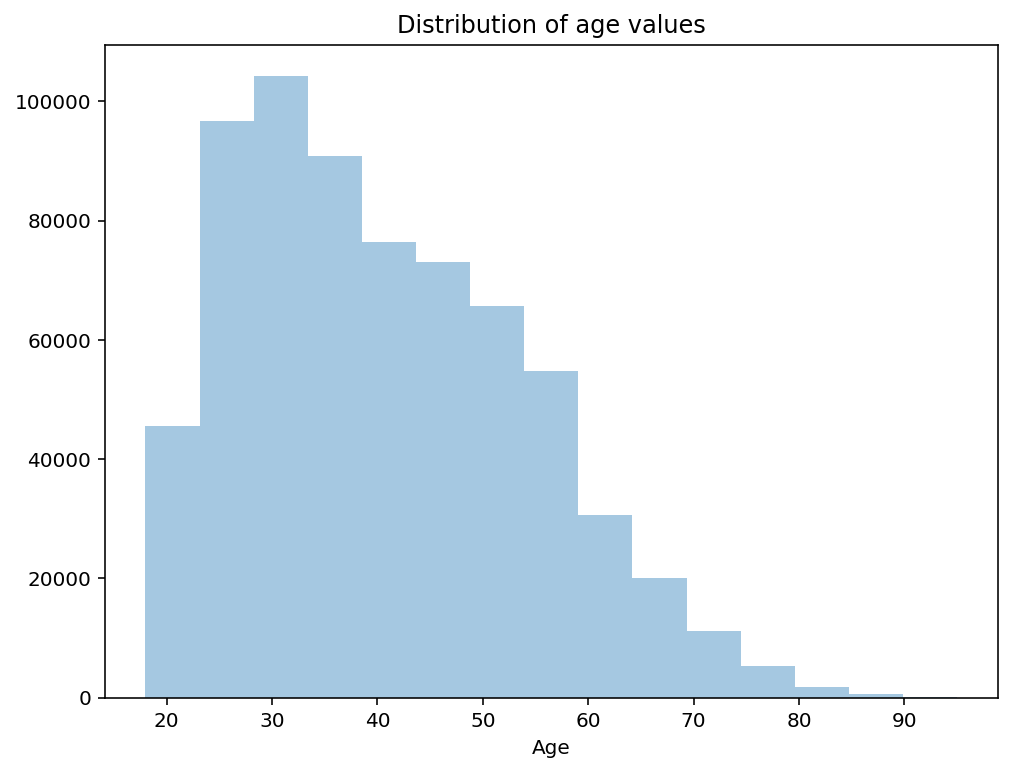

In [20]:
plt.figure()
sns.distplot(df['age'], bins=15, kde=False)
plt.xlabel('Age')
plt.title('Distribution of age values')
plt.show()

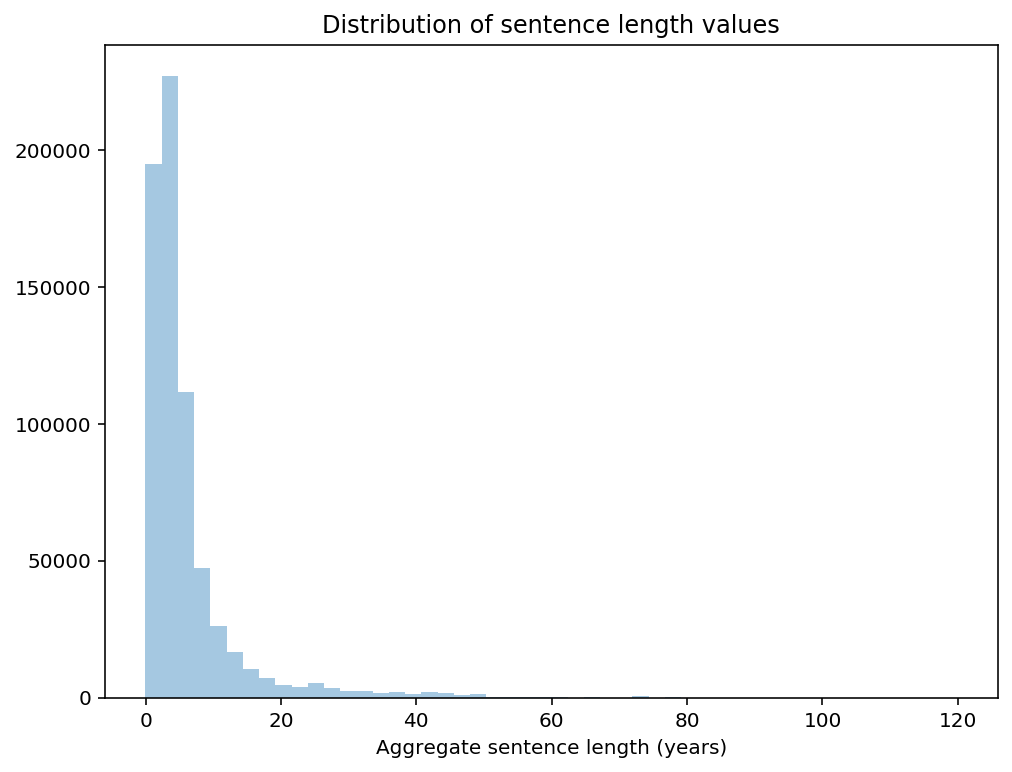

In [21]:
plt.figure()
sns.distplot(df['aggregate_sentence_length'] / 365, kde=False)
plt.xlabel('Aggregate sentence length (years)')
plt.title('Distribution of sentence length values')
plt.show()

## Consolidating race column

Following the *Globe*'s methodology, we will consolidate the 33 races in the `race` column into simpler groupings (such as Black, Indigenous, White and Latino), using [Ontario's Data Standards for the Identification and Monitoring of Systemic Racism](https://files.ontario.ca/solgen_data-standards-en.pdf). Since our analysis, like the *Globe*'s, is focused on the differences between White, Black and Indigenous inmates, we further consolidate other races into an "other" category.

In [22]:
race_dict = {'White':'White',
             'Euro.-Southern':'White', 
             'Euro.-Eastern':'White',
             'Euro.-Western':'White',
             'Euro.-Northern':'White',
             'British Isles':'White',
             'European French':'White',
             'Black':'Black',
             'Caribbean':'Black',
             'Sub-Sahara Afri':'Black',
             'North American':'Indigenous',
             'Metis':'Indigenous', 
             'Inuit':'Indigenous'}

In [23]:
df['race'] = df['race'].map(race_dict)
df['race'] = df['race'].fillna('Other')

## Transforming multilevel columns

Various columns are encoded as either `LOW`, `MEDIUM`, or `HIGH`, where `LOW` indicates a negative assessment, `HIGH` indicates a positive assessment, and `MEDIUM` indicates that there wasn't sufficient evidence to issue an assessment in either direction. As such, I believe it makes sense to encode these columns numerically, as `-1`, `0`, or `1`.

In [24]:
lmh_dict = {'LOW':-1,
            'MEDIUM':0,
            'HIGH':1}

In [25]:
# Loop through low/medium/high columns
for col in ['static/risk', 'dynamic/need', 'motivation', 'reintegration_potential']:

    # Encode values numerically
    df[col] = df[col].map(lmh_dict)

The `security/supervision` column has eight different values; we will one-hot encode these values as separate columns.

In [26]:
# Transform security/supervision column with one-hot encoding
df['security/supervision'] = df['security/supervision'].str.lower().str.replace(' ', '_')
secsup_dummies = pd.get_dummies(df['security/supervision'], prefix='sec/sup').drop(f'sec/sup_long_term_super', axis=1)
df = pd.concat([df, secsup_dummies], axis=1).drop('security/supervision', axis=1)

## Binning age & sentence length values

In [27]:
df['age'] = pd.qcut(df['age'], 10, labels=np.arange(.1,1.1,.1)).astype(float)
df['aggregate_sentence_length'] = pd.qcut(df['aggregate_sentence_length'] / 365.25, 10, labels=np.arange(.1,1.1,.1)).astype(float)

## Filtering to top offences

In [28]:
# Lowercase column values & replace whitespaces with underscores
df['offence_description'] = df['offence_description'].str.lower().str.replace(' ', '_')

In [29]:
# Get normalized value counts for all offence descriptions
offence_pcts = df['offence_description'].value_counts(normalize=True)

In [30]:
# Filter to offence descriptions that appear in more than 0.1% of the data
offence_pcts[offence_pcts > .001]

robbery_-_all_others                       0.050649
fail_to_comply_w/cond_of_under/recog       0.043028
break_enter_and_commit                     0.041008
poss_schedule_i/ii_subst_for_purp_traff    0.038402
fail_to_comply_w/_probation_order          0.034956
                                             ...   
production_of_sched_i/ii_subst             0.001041
attempt                                    0.001021
disobey_order_of_court                     0.001013
traffic_in_schedule_iii_substance          0.001013
procures/poss/sells_identity_document      0.001010
Name: offence_description, Length: 138, dtype: float64

In [31]:
# Create a list of these top offences
top_offences = offence_pcts[offence_pcts > .001].index.tolist()

In [32]:
# Filter dataframe to only rows with one of these top offences
df_filtered = df[df['offence_description'].isin(top_offences)].reset_index(drop=True)

## Transforming data

In [33]:
# Dummify offence description column
offence_dummies = pd.get_dummies(df_filtered['offence_description'], prefix='offence')

There are two ways we may want to aggregate our dummified offence description columns: We can either record the inmate's total number of charges for each offence type, or we can simply record whether or not the inmate was charged with each offence type (regardless of the total number of charges). It's not clear to me which method will be better for modelling purposes, so I'll here do both.

In [34]:
# Add dummy columns to dataframe's Offender ID & year columns
df_off_dummies = pd.concat([df_filtered['id'], offence_dummies], axis=1)

# Group dataframe and take the sum
df_off_sum = df_off_dummies.groupby('id').sum()

# Group dataframe and take the max
df_off_binary = df_off_dummies.groupby('id').max()

## Stitching it all together

An individual inmate may occupy multiple rows in the dataframe in a given year, one row for each of their offences. In these cases, only the `offence_description` column differs; all of the other columns are the same. Thus, we can consolidate all of the inmate's other information by dropping the `offence_description` column and dropping all duplicate rows.

In [35]:
# Drop offence description column
df_stats = df.drop('offence_description', axis=1)

# Drop duplicates to collapse each year/offender into a single record
df_stats.drop_duplicates(inplace=True)

We can now combine dummified offence description dataframes with our new inmate statistics dataframe, by joining these dataframes together on the unique `id` column.

In [36]:
df_sum = df_stats.join(df_off_sum, on='id', how='inner')
df_binary = df_stats.join(df_off_binary, on='id', how='inner')

In [37]:
# Write dataframes to file
df_sum.to_csv('~/data/ParoleModels/df_sum.csv', index=False)
df_binary.to_csv('~/data/ParoleModels/df_binary.csv', index=False)